# Principal component analysis (part 2)

This notebook contains the code for the second part in the PCA series: [peterbloem.nl/blog/pca-2](peterbloem.nl/blog/pca-2). There isn't much here in the way of implementations of algorithms. Just the code required for various plots.

In [1]:
RED  = '#B13E26'
LRED = '#D38473'
BLUE = '#306693'
LBLUE = '#86B3D9'
GREEN = '#677d00'
LGREEN = '#acd373'
ORANGE = '#E69500'

import util

import numpy as np
import numpy.linalg as la

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import lines

from matplotlib import rcParams
rcParams['font.family'] = 'Georgia'

%matplotlib inline
import sklearn

import torch
from torch import nn
from torch.optim import SGD, Adam

from tqdm import trange, tqdm

from sklearn.decomposition import PCA
import pandas as pd

import math

def clean(ax=None):
    # turn everything off
    if ax is None:
        ax = plt.gca()
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

def ca(ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.set_xticks([]) 
    ax.set_yticks([]) 
            
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off', top='off', right='off', left='off',
        labelbottom='off', labelleft='off') # labels along the bottom edge are off

def center(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['left'].set_position('center')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('center')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom='off', labelleft='off')
    
    ax.set_aspect('equal')
    
def zero(ax=None):
    if ax is None:
        ax = plt.gca()
    ax.spines['left'].set_position('zero')
    ax.spines['right'].set_color('none')
    ax.spines['bottom'].set_position('zero')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    
    ax.tick_params(
    axis='both',       # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    labelbottom='off', labelleft='off')
    
    ax.set_aspect('equal')

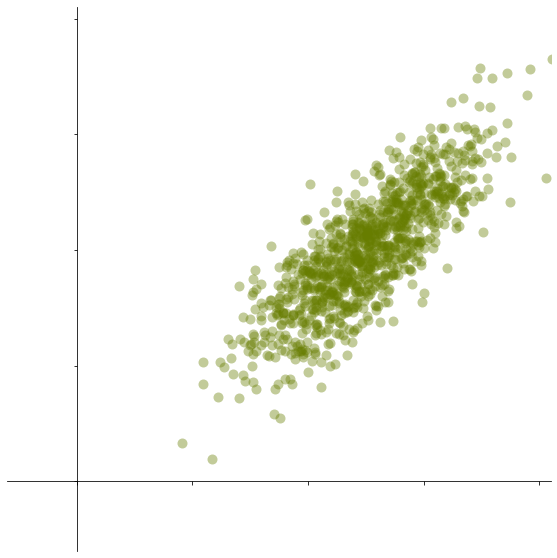

In [2]:
# generate some data with strong covariance

cov =  np.asarray([[1, .8], [0.8, 1]])
mean = np.asarray([5, 4])
x = np.random.multivariate_normal(mean, cov, size=1000)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(x[:, 0], x[:, 1], color=GREEN, alpha=0.4, s=100, linewidths=0)

zero(ax)
ax.tick_params(labelbottom=False, labelleft=False)

ax.set_xlim(-1.2, 8.2)
ax.set_ylim(-1.2, 8.2)

plt.savefig('covariance.svg', transparent=False, bbox_inches='tight', pad_inches=0)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


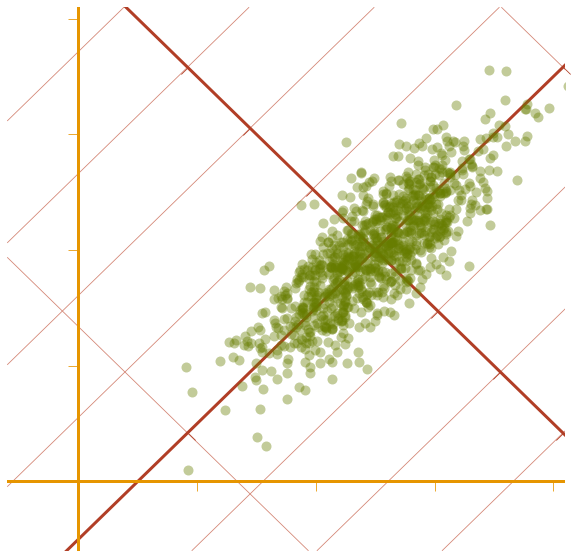

In [413]:
# Show the data in the standard basis and the eigenbasis

import matplotlib.ticker as ticker
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axisartist.grid_finder import (FixedLocator, MaxNLocator,
                                                 DictFormatter)
def axstyle(ax, c='k'):
    """
    Utility function for styling axes
    """
    ax.line.set_color(c)
    ax.major_ticks.set_color(c)
    ax.major_ticks.set_ticksize(10)
    ax.major_ticks.set_linewidth(8)
    ax.major_ticklabels.set_visible(False)
    ax.line.set_linewidth(3)

# Perform the eigendecomp on the covariance matrix
w, v = np.linalg.eig(cov)

# inverse of the A matrix from the blog post.
ai = v.T.dot( np.diag(w ** -.5) )

# Turn into a 3x3 matrix to put transformation and translation in one matrix.
mat = np.concatenate([ai, mean[:, None]], axis=1)
mat = np.concatenate([mat, np.asarray([[0, 0, 1]])], axis=0)
tr = Affine2D(matrix=mat)

fig = plt.figure(figsize=(10, 10))

ticks = np.arange(-100, 100, 2)

# We use a curvilinear projection to plot the eigenbasis axes
grid_helper = GridHelperCurveLinear(tr, 
    grid_locator1=FixedLocator(ticks),
    grid_locator2=FixedLocator(ticks))

# We plot both bases by overlaying two subplots: one with the curvilinear 
# transform, one standard.
ax = AA.Subplot(fig, 111, grid_helper=grid_helper, zorder=-1)

ax2 = AA.Subplot(fig, 111, zorder=1)
ax2.patch.set_alpha(0.0)

fig.add_subplot(ax)
fig.add_subplot(ax2)

# Remove all standard axes
ax.axis['top', 'right', 'bottom', 'left'].set_visible(False)
ax2.axis['top', 'right', 'bottom', 'left'].set_visible(False)

# add zero-centered axes for the standard basis
ax2.axis['midx'] = ax2.new_floating_axis(nth_coord=0, value=0)
ax2.axis['midy'] = ax2.new_floating_axis(nth_coord=1, value=0)

# add transformed axes for the eigenbasis
ax.axis['eigenx'] = ax.new_floating_axis(0, 0)
ax.axis['eigeny'] = ax.new_floating_axis(1, 0)

ax2.axis['midx'].invert_ticklabel_direction()
ax.axis['eigeny'].invert_ticklabel_direction()
ax.axis['eigenx'].invert_ticklabel_direction()

axstyle(ax.axis['eigenx'], c=RED)
axstyle(ax.axis['eigeny'], c=RED)
axstyle(ax2.axis['midx'], c=ORANGE)
axstyle(ax2.axis['midy'], c=ORANGE)

ax2.scatter(x[:, 0], x[:, 1], color=GREEN, alpha=0.4, s=100, linewidths=0)

# ax.set_aspect(1)
ax2.set_xlim(-1.2, 8.2)
ax2.set_ylim(-1.2, 8.2)
ax.set_xlim(-1.2, 8.2)
ax.set_ylim(-1.2, 8.2)

ax.grid(True, zorder=0, color=LRED, alpha=1)


plt.savefig('covariance-2.svg', transparent=False, bbox_inches='tight', pad_inches=0)

[[ 0.70710678 -0.70710678]
 [ 0.70710678  0.70710678]]


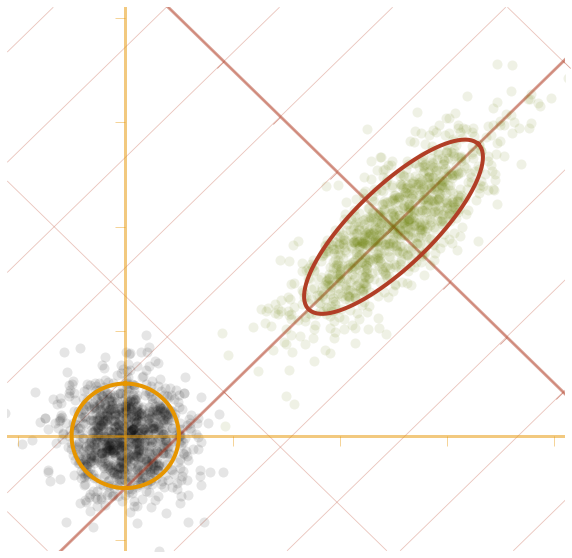

In [420]:
# Same as before, but with ellipses, and whitened data added.

import matplotlib.ticker as ticker
import mpl_toolkits.axisartist as AA
from mpl_toolkits.axisartist.grid_finder import (FixedLocator, MaxNLocator,
                                                 DictFormatter)
def axstyle(ax, c='k'):
    ax.line.set_color(c)
    ax.major_ticks.set_color(c)
    ax.major_ticks.set_ticksize(10)
    ax.major_ticks.set_linewidth(8)
    ax.major_ticks.set_alpha(0.5)
    ax.major_ticklabels.set_visible(False)
    ax.line.set_linewidth(3)
    ax.line.set_alpha(0.5)

    
# cov =  np.asarray([[1, .8], [0.8, 1]])
# mean = np.asarray([5, 4])
# x = np.random.multivariate_normal(mean, cov, size=1000)

w, v = np.linalg.eig(cov)

# a = np.diag(w ** -0.5).dot( v.T )
ai = v.T.dot( np.diag(w ** - .5) )

print(v)


mat = np.concatenate([ai, mean[:, None]], axis=1)
mat = np.concatenate([mat, np.asarray([[0, 0, 1]])], axis=0)
                      
tr = Affine2D(matrix=mat)

fig = plt.figure(figsize=(10, 10))

ticks = np.arange(-100, 100, 2)
grid_helper = GridHelperCurveLinear(tr, 
    grid_locator1=FixedLocator(ticks),
    grid_locator2=FixedLocator(ticks))

ax = AA.Subplot(fig, 111, grid_helper=grid_helper, zorder=-1)

ax2 = AA.Subplot(fig, 111, zorder=1)
ax2.patch.set_alpha(0.0)

fig.add_subplot(ax)
fig.add_subplot(ax2)

ax.axis['top', 'right', 'bottom', 'left'].set_visible(False)
ax2.axis['top', 'right', 'bottom', 'left'].set_visible(False)

ax2.axis['midx'] = ax2.new_floating_axis(nth_coord=0, value=0)
ax2.axis['midy'] = ax2.new_floating_axis(nth_coord=1, value=0)

ax.axis['eigenx'] = ax.new_floating_axis(0, 0)
ax.axis['eigeny'] = ax.new_floating_axis(1, 0)

ax2.axis['midx'].invert_ticklabel_direction()
ax.axis['eigeny'].invert_ticklabel_direction()
ax.axis['eigenx'].invert_ticklabel_direction()

axstyle(ax.axis['eigenx'], c=RED)
axstyle(ax.axis['eigeny'], c=RED)
axstyle(ax2.axis['midx'], c=ORANGE)
axstyle(ax2.axis['midy'], c=ORANGE)

ax2.scatter(x[:, 0], x[:, 1], color=GREEN, alpha=0.1, s=100, linewidths=0)

# plot the whitened data as well
z = tr.inverted().transform(x)
ax.scatter(z[:, 0], z[:, 1], color='k', alpha=0.1, s=100, linewidths=0)

# plot the bi-unit circle
ang = np.linspace(0, math.pi*2, 100)[:, None]
xy = np.concatenate([np.sin(ang), np.cos(ang)], axis=1)
# ... and the transformed ellipse
el = tr.transform(xy)

ax2.plot(xy[:,0], xy[:,1], color=ORANGE, alpha=1., lw=4)
ax2.plot(el[:,0], el[:,1], color=RED, alpha=1., lw=4)

# ax.set_aspect(1)
ax2.set_xlim(-2.2, 8.2)
ax2.set_ylim(-2.2, 8.2)
ax.set_xlim(-2.2, 8.2)
ax.set_ylim(-2.2, 8.2)

ax.grid(True, zorder=0, color=LRED, alpha=0.5)


plt.savefig('covariance-ellipses.svg', transparent=False, bbox_inches='tight', pad_inches=0)

<ipython-input-43-8bded6f60686>:2: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{eulervm}']


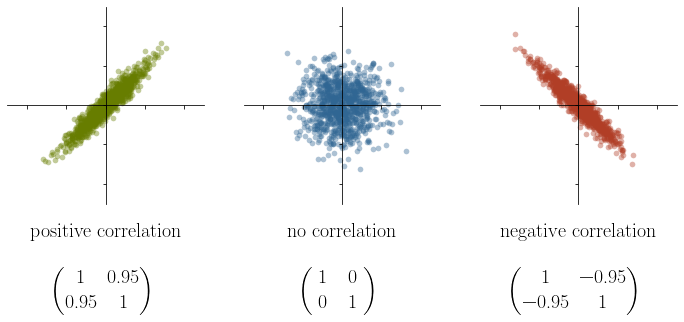

In [43]:
# Three types of correlation.

mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath} \usepackage{eulervm}']


# generate some data with different covariances
kw = {'y': -0.5, 'fontsize': 20}

fig = plt.figure(figsize=(12, 4))
ax1, ax2, ax3 = fig.subplots(1, 3, sharey=True)

x = np.random.multivariate_normal([0, 0], [[1, 0.95], [0.95, 1]], size=1000)
ax1.scatter(x[:, 0], x[:, 1], color=GREEN, alpha=0.4, s=32, linewidths=0)

zero(ax1) # $\begin{pmatrix}1 & 0.95\\ 0.95 & 1\end{pmatrix}$
ax1.tick_params(labelbottom=False, labelleft=False)   
ax1.set_title('positive correlation \n\n'+ r'$\begin{pmatrix}1 & 0.95\\ 0.95 & 1\end{pmatrix}$', **kw)
ax1.set_xlim(-5, 5); ax1.set_ylim(-5, 5)

x = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], size=1000)
ax2.scatter(x[:, 0], x[:, 1], color=BLUE, alpha=0.4, s=32, linewidths=0)

zero(ax2)
ax2.tick_params(labelbottom=False, labelleft=False)   
ax2.set_title('no correlation \n\n'+ r'$\begin{pmatrix}\;1\;\; & 0\;\\ \;0\;\; & 1\;\end{pmatrix}$', **kw)
ax2.set_xlim(-5, 5); ax2.set_ylim(-5, 5)

x = np.random.multivariate_normal([0, 0], [[1, -0.95], [-0.95, 1]], size=1000)
ax3.scatter(x[:, 0], x[:, 1], color=RED, alpha=0.4, s=32, linewidths=0)
ax3.set_title('negative correlation \n\n'+ r'$\begin{pmatrix}1 & -0.95\\ -0.95 & 1\end{pmatrix}$', **kw)
ax3.set_xlim(-5, 5); ax3.set_ylim(-5, 5)

zero(ax3)
ax3.tick_params(labelbottom=False, labelleft=False)   

plt.savefig('covs-3.svg', transparent=False, bbox_inches='tight', pad_inches=0)

In [44]:
# Computing the inverse for the (handdrawn) basis transformetion

b = np.asarray([[0.9, 0.7], [0.4, 0.7]])
binv = np.linalg.inv(b)

binv.dot([[3],[2]])

array([[2.        ],
       [1.71428571]])

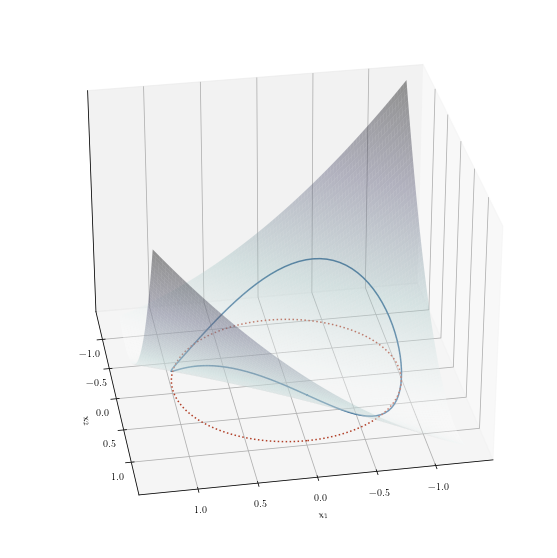

In [97]:
# Plot a 2D parabola with a bi-unit circle projected

from matplotlib.patches import Circle
import mpl_toolkits.mplot3d.art3d as art3d

def parab(x, y):
    return 2*x**2  +  7*x*y +  5*y**2

xr = (-1.3, 1.3)
yr = (-1.3, 1.3)

h = 1000 # step nums in the mesh
xx, yy = np.meshgrid(np.arange(xr[0], xr[1], (xr[1] - xr[0])/h),
                     np.arange(yr[0], yr[1], (yr[1] - yr[0])/h))

values = parab(xx.ravel(), yy.ravel())
values = values.reshape(xx.shape)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 80)

ax.plot_surface(xx, yy, values, rstride=10, cstride=10, cmap='bone_r', alpha=0.4, zorder=-1)

ang = np.linspace(0, math.pi*2, 100)
x = np.sin(ang)
y = np.cos(ang)
v = parab(x, y)

ax.plot(x, y, v, color=BLUE, alpha=1.)
ax.plot(x, y, 0, color=RED, alpha=1., linestyle=':')

ax.set_zlim(bottom=0)

ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
                              
ax.set_zticks([])

plt.savefig('surface.svg')